# Proyecto Final - Especialización en Inteligencia Artificial  

Alumno: Emmanuel Cardozo

Título: Clasificación de calidad de manzanas verdes.

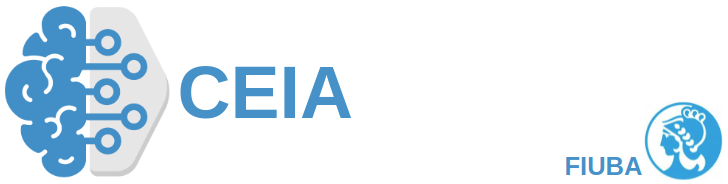

Este código incluye la implementación de un clasificador de calidad de manzanas verdes mediante visión por computadora implementado con la biblioteca Torchvision de Pytorch

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#PyTorch stuff
import json 
import requests 
import warnings 
import torch
torch.manual_seed(0)
from PIL import Image
from torch import optim, nn
from torch.nn import functional as F
from torchvision import transforms as T
from torchvision import models, datasets
from torch.utils.data import DataLoader, Dataset, random_split

#for jupyter themes users
from jupyterthemes import jtplot
jtplot.style()  

c:\Users\Emmanuel\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### GPU

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


###  ResNeXt101

In [3]:
resneXt = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resneXt')
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')

resneXt.eval().to(device)

Using cache found in C:\Users\Emmanuel/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub
C:\Users\Emmanuel/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub\PyTorch\Classification\ConvNets\image_classification\models\common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
C:\Users\Emmanuel/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub\PyTorch\Classification\ConvNets\image_classification\models\efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
Using cache found in C:\Users\Emmanuel/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layers): Sequential(
    (0): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
    

## ResNext 50 y 101

In [4]:

import torch
resneXt50_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnext50_32x4d', pretrained=True)
resneXt101_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnext101_32x8d', pretrained=True)
resneXt50_model.eval()

Using cache found in C:\Users\Emmanuel/.cache\torch\hub\pytorch_vision_v0.10.0
Using cache found in C:\Users\Emmanuel/.cache\torch\hub\pytorch_vision_v0.10.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

###  Datasets y Dataloaders

In [5]:
PATH_TRAIN = 'processed_data/train/'
PATH_TEST = 'processed_data/test'
PATH_VALIDATION = 'processed_data/val'
MINIBATCH_SIZE = 512

transform_train = T.Compose([
                T.Resize(128),
                T.RandomHorizontalFlip(p=0.3),
                T.ColorJitter(brightness=0.1, contrast=0.1, hue = 0.05),
                #T.RandomApply([T.RandomRotation(10), T.Resize(40), T.CenterCrop(32)], p = 0.1),
                T.ToTensor(),
                T.Normalize([0.491, 0.482, 0.447], [0.247, 0.243, 0.262])
            ])
transform_test = T.Compose([
                T.Resize(128),
                T.ToTensor(),
                T.Normalize([0.491, 0.482, 0.447], [0.247, 0.243, 0.262])
            ])

# Training set loader
train_dataset = datasets.ImageFolder(PATH_TRAIN, transform=transform_train)
train_loader = DataLoader(train_dataset, batch_size=MINIBATCH_SIZE, shuffle = True)

# Validation and test sets
test_dataset = datasets.ImageFolder(PATH_TEST, transform=transform_test)
val_dataset = datasets.ImageFolder(PATH_VALIDATION, transform=transform_train)

test_loader = DataLoader(test_dataset, batch_size=MINIBATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size=MINIBATCH_SIZE, shuffle = True)

### Mostrar datos

La imagen muestreada representa un: defective apple


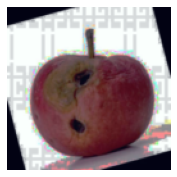

In [6]:
classes = train_loader.dataset.classes
def plot_figure(image):
    plt.figure(figsize=(3,3))
    plt.imshow(np.transpose(image,(1,2,0)))
    plt.axis('off')
    plt.show()

rnd_sample_idx = np.random.randint(len(test_loader))
print(f'La imagen muestreada representa un: {classes[test_loader.dataset[rnd_sample_idx][1]]}')
image = test_loader.dataset[rnd_sample_idx][0]
image = (image - image.min()) / (image.max() -image.min() )
plot_figure(image)

##### Las imágenes tiene unas dimensiones de 3x640x640. Transponemos sus dimensiones para ver la segunda dimensión:

In [7]:
#Prueba
sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
img = train_dataset[sample_idx][0]
img = np.transpose(img,(1,2,0)) #El tensor img es de 3x640x640. Luego de transponerlo, el tensor es de 640x640x3
len(img)

128

### Visualizamos algunas imágenes del dataset:

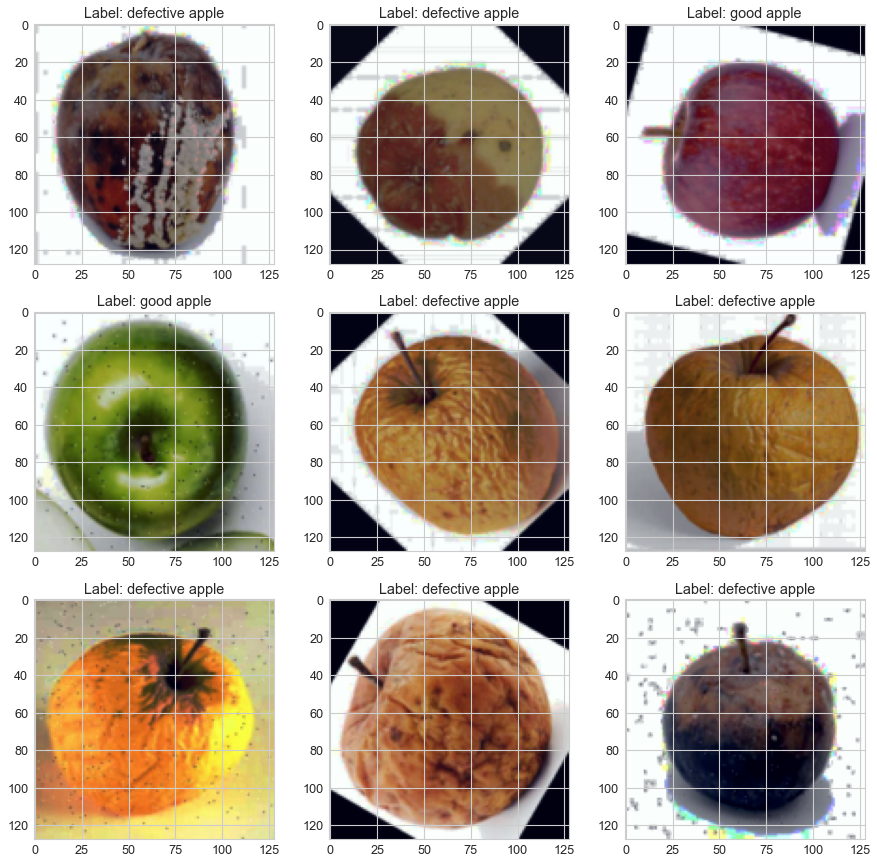

In [8]:
def plot_imagefolder_grid_rand():
    figure = plt.figure(figsize=(15, 15))
    cols, rows = 3, 3
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
        img = train_dataset[sample_idx][0]
        figure.add_subplot(rows, cols, i)
        #plt.axis("off")
        img = np.transpose(img,(1,2,0))
        img = (img - img.min()) / (img.max() -img.min() )
        plt.imshow(img.squeeze())
        plt.title(f'Label: {classes[train_loader.dataset[sample_idx][1]]}')
    plt.show()

plot_imagefolder_grid_rand()


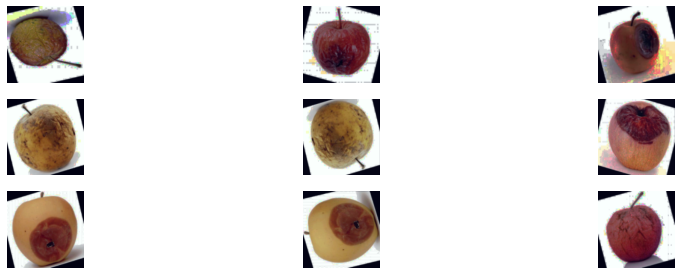

In [9]:
def plot_imagefolder_grid():
    classes = train_loader.dataset.classes
    total_samples = 9
    plt.figure(figsize=(15,15))
    for label, sample in enumerate(classes):
        class_idxs = np.flatnonzero(np.array(classes))
        sample_idxs = np.random.choice(class_idxs, 3, replace = False) 
        for i, idx in enumerate(sample_idxs):
            plt_idx = idx*len(classes) + label + 1
            img = train_dataset[plt_idx][0]
            img = np.transpose(img,(1,2,0))
            img = (img - img.min()) / (img.max() -img.min() )
            plt.subplot(total_samples, len(classes), plt_idx)
            plt.axis('off')
            plt.imshow(img.squeeze())
        if i == 0: plt.title(sample)
    plt.show()

plot_imagefolder_grid() 

### Chequeo de las clases del dataset

In [10]:
classes = train_loader.dataset.classes
classes

['defective apple', 'good apple', 'regular apple']

### ResneXt

In [11]:
model = resneXt50_model
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(2048, len(classes))
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

### Training

In [12]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [13]:
def accuracy(model, loader):
    correct = 0
    total = 0
    cost = 0
    model.eval()
    model = model.to(device=device)
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            cost += (F.cross_entropy(scores, y)).item()
            _, pred = scores.max(dim=1)
            correct += (pred == y).sum()
            total += pred.size(0)
        return cost/len(loader), float(correct)/total

In [14]:
def train(model, optimizer, train_loader, scheduler = None, epochs = 100):
    model = model.to(device = device)
    val_loss_history = []
    train_loss_history = []
    val_acc_history = []
    train_acc_history = []
    lrs = []
    train_cost = 0.
    val_cost = 0.
    train_cost_acum = 0
    for epoch in range(epochs):
        train_correct_num  = 0
        train_total = 0
        train_cost_acum = 0
        for mb, (x, y) in enumerate(train_loader, start=1):
            model.train()
            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            cost = F.cross_entropy(input=scores, target=y)
            optimizer.zero_grad()
            cost.backward()
            optimizer.step()
            #if using scheduler
            if scheduler: scheduler.step()
                
            train_correct_num += (torch.argmax(scores, dim=1) == y).sum()
            train_total += scores.size(0)        
            train_cost_acum += cost.item()
            train_acc = float(train_correct_num)/train_total  
#             train_cost = train_cost_acum/mb
            val_cost, val_acc = accuracy(model, val_loader)

            #val_loss_history.append(val_cost)
            #train_loss_history.append(cost.item())
            #val_acc_history.append(val_acc)
            #train_acc_history.append(train_acc)
#             lrs.append(scheduler.get_last_lr()[0])
            lrs.append(optimizer.param_groups[0]["lr"])
        
        #f'last lr: {scheduler.get_last_lr()[0]:6f},
        
        train_acc = float(train_correct_num)/train_total
        train_cost = train_cost_acum/len(train_loader)

        train_acc_history.append(train_acc)
        train_loss_history.append(train_cost)
        val_acc_history.append(val_acc)
        val_loss_history.append(val_cost)
        

        print(f'Epoch:{epoch}, train cost: {train_cost:.6f}, val cost: {val_cost:.6f},'
                      f' train acc: {train_acc:.4f}, val acc: {val_acc:4f}, total: {train_total},'
                      f' lr: {optimizer.param_groups[0]["lr"]:.6f}')
        
    return train_loss_history, val_loss_history, train_acc_history, val_acc_history, lrs

In [15]:
train_loss_hist, val_loss_hist, train_acc_hist, val_acc_hist, lrs_ = train(model, optimizer, train_loader, scheduler = None, epochs = 15)

Epoch:0, train cost: 1.135135, val cost: 0.914685, train acc: 0.3347, val acc: 0.595573, total: 1494, lr: 0.001000
Epoch:1, train cost: 0.893070, val cost: 0.935483, train acc: 0.6111, val acc: 0.615694, total: 1494, lr: 0.001000
Epoch:2, train cost: 0.919605, val cost: 0.879020, train acc: 0.6151, val acc: 0.615694, total: 1494, lr: 0.001000
Epoch:3, train cost: 0.821975, val cost: 0.692472, train acc: 0.6198, val acc: 0.748491, total: 1494, lr: 0.001000
Epoch:4, train cost: 0.708828, val cost: 0.700566, train acc: 0.7637, val acc: 0.788732, total: 1494, lr: 0.001000
Epoch:5, train cost: 0.693972, val cost: 0.630333, train acc: 0.8079, val acc: 0.824950, total: 1494, lr: 0.001000
Epoch:6, train cost: 0.606741, val cost: 0.568924, train acc: 0.8240, val acc: 0.820926, total: 1494, lr: 0.001000
Epoch:7, train cost: 0.568160, val cost: 0.553971, train acc: 0.7778, val acc: 0.776660, total: 1494, lr: 0.001000
Epoch:8, train cost: 0.555568, val cost: 0.543142, train acc: 0.7704, val acc: 0

In [16]:
accuracy(model, test_loader)

(0.41649094223976135, 0.8562874251497006)

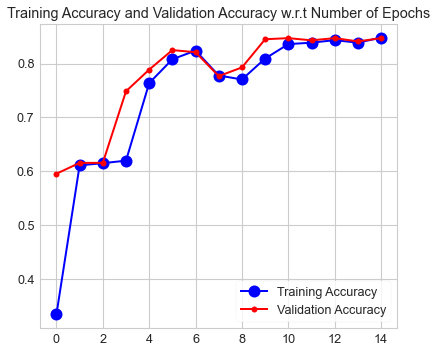

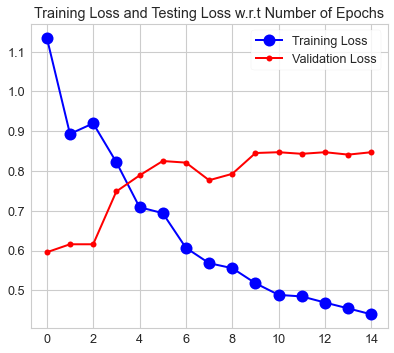

In [17]:
No_Of_Epochs = range(15)

plt.plot(No_Of_Epochs, train_acc_hist, marker = 'o', color = 'blue', markersize = 12, 
                 linewidth = 2, label = 'Training Accuracy')
plt.plot(No_Of_Epochs, val_acc_hist, marker = '.', color = 'red', markersize = 12, 
                 linewidth = 2, label = 'Validation Accuracy')

plt.title('Training Accuracy and Validation Accuracy w.r.t Number of Epochs')

plt.legend()

plt.figure()

plt.plot(No_Of_Epochs, train_loss_hist, marker = 'o', color = 'blue', markersize = 12, 
                 linewidth = 2, label = 'Training Loss')
plt.plot(No_Of_Epochs, val_acc_hist, marker = '.', color = 'red', markersize = 12, 
                 linewidth = 2, label = 'Validation Loss')

                 
plt.title('Training Loss and Testing Loss w.r.t Number of Epochs')

plt.legend()

plt.show()